# NEST SIMULATION 
##### 1. IMPORTING RELEVANT DATA FROM SNUDDA GENERATED NEURON FILES:\
    a) Neuron Matrix: to keep the info of neuron types \
    b) Synaptic Matrix: Where each row has the info of [preID, posID] of one synapse \
    for now every synapse will have the same properties, no matter the types of neurons\
    (later we can add more info on this matrix that will help set the type of synapses used for each)\
    c*) (optional/not really relevant but already available) Positions: matrix with coordinates for each neuron position\
    d) Info about the input given to the neurons
##### 2) CREATING THE NEST NETWORK \
    a) Create the neurons (the correct # of neurons, in their posiiton*)\
    b) Connect the neurons (for loop with Synaptic Matrix as info)\
    c) Connect the measuring devices to the neurons in order to observe spiking and voltage \
    d) Create the spike generators to feed the input 
##### 3) RUN THE SIM
    

### 0. LIBRARIES

In [2]:
import nest
import matplotlib.pyplot as plt

from getData import *
from plot import *

### 1. IMPORTING DATA

In [3]:
positions_list = getNeuronPositions('net_100')

synaptic_matrix = getSynapses('net_100')

input_matrix = getInput('net_100', 100)

### 2. CREATING THE NEST NETWORK

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [4]:
pos = nest.spatial.free(positions_list) # using NEURON positions

Now we create all the neurons at once, with same characteristics. They are all conductance based integrate and fire model, with the default parameters of nest.\
(to accomodate differente models, this will have to be upgraded, so that the creation parameters can change according to type. once this is done changes in the connection protocol will be needed, bc they wont all be in the same population) [idea: if possible to apply changes with "set" command instead of in the moment of creation, to make it easier]

In [5]:
s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) 

With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

In [6]:
pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()

With the arrays ready, we can connect the synapses all in one command.
(again here, if we wish to have different parameters and arguments for each synapse, a more complex solution is necessary.)

In [7]:
syn_matrix = getWeightedSynpses(pre_array,pos_array)

[[ 1 15  3]
 [ 1 31  3]
 [ 1 54  3]
 ...
 [99 92  4]
 [99 93  2]
 [99 98  5]]


In [13]:
neuron_IDs = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

syn_wgt = [] 
conductances = []
for i in range(0,len(syn_matrix)):
    
    neuron_type = neuron_IDs[syn_matrix[i][0]-1][1]
        
    if (neuron_type == 'dspn' or neuron_type == 'ispn' ):
        #"conductance": [2.4e-10, 1e-10]
        cond = np.random.normal(2.4e-10,  1e-10, 1)
        
        if(cond<2.4e-11): #capping at 10% of mean
            cond = 2.4e-11
    elif (neuron_type == 'lts'):
        # conductance mean = 3e-09, std deviation =  0
        cond = 3e-09
        
    elif (neuron_type == 'fs'):
        #"conductance": [1.1e-09, 1.5e-09],
        cond = np.random.normal(1.1e-09, 1.5e-09, 1)
        
        if(cond<1.1e-10): #capping at 10% of mean
            cond = 1.1e-10
    
    conductances.append(cond)
    
print(conductances)
    

[array([1.38920541e-10]), array([2.61209333e-10]), array([2.56878956e-10]), array([2.97595269e-10]), array([3.286893e-10]), array([1.64786575e-10]), array([1.86254725e-10]), array([2.31915674e-10]), array([1.87790672e-10]), array([2.28848146e-10]), array([2.48671286e-10]), array([4.06239252e-11]), array([2.67902246e-10]), array([3.32478265e-10]), array([2.24568356e-10]), array([3.82407387e-10]), array([4.19016348e-10]), array([4.91323458e-10]), array([3.53095376e-10]), array([6.70229399e-11]), array([3.74956608e-10]), array([1.46083502e-10]), array([1.83809134e-10]), array([2.22997963e-10]), array([1.28193069e-10]), array([3.01710127e-10]), array([2.28810931e-10]), array([2.27123196e-10]), array([2.89396751e-10]), array([2.45537915e-10]), array([2.27183919e-10]), array([2.16220081e-10]), array([3.25462619e-10]), array([1.98828788e-10]), array([2.90955695e-10]), array([2.3014558e-10]), array([7.69636087e-11]), array([2.31331844e-10]), array([1.88005906e-10]), array([1.78968123e-10]), ar

In [16]:
weights = []
for i in range(0, len(conductances)):
    weights.append(-1*conductances[i]*syn_matrix[i][2])
print(weights)

[array([-4.16761623e-10]), array([-7.83627999e-10]), array([-7.70636869e-10]), array([-8.92785806e-10]), array([-6.57378601e-10]), array([-4.94359725e-10]), array([-5.58764174e-10]), array([-6.95747021e-10]), array([-3.75581345e-10]), array([-4.57696293e-10]), array([-7.46013858e-10]), array([-1.21871776e-10]), array([-1.07160898e-09]), array([-6.6495653e-10]), array([-6.73705068e-10]), array([-1.52962955e-09]), array([-1.67606539e-09]), array([-1.47397037e-09]), array([-1.05928613e-09]), array([-1.3404588e-10]), array([-1.12486982e-09]), array([-4.38250505e-10]), array([-5.51427402e-10]), array([-6.68993889e-10]), array([-6.40965347e-10]), array([-9.0513038e-10]), array([-6.86432794e-10]), array([-6.81369587e-10]), array([-5.78793501e-10]), array([-7.36613746e-10]), array([-9.08735677e-10]), array([-6.48660243e-10]), array([-9.76387856e-10]), array([-5.96486365e-10]), array([-5.81911391e-10]), array([-6.90436741e-10]), array([-3.84818044e-10]), array([-6.93995533e-10]), array([-3.7601

In [19]:
sources = syn_matrix[:,0]
targets = syn_matrix[:,1]

In [20]:
nest.Connect(sources,targets,conn_spec= "one_to_one", syn_spec= {"weight": weights})

Now onto the creation of the Spike Generators.

In [21]:
inputs = nest.Create("spike_generator", 99)

In [22]:
for g, generator in enumerate(inputs):
    
    #spk_wgt = np.full(len(input_matrix[g]), 2.0)
    #nest.SetStatus(generator, {"spike_times": input_matrix[g], "spike_weights": spk_wgt})
    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [23]:
spikerecorder = nest.Create("spike_recorder")

In [24]:
input_syn_wgt = np.full(len(inputs), 10.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})

In [25]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [26]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [27]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

### RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [28]:
nest.Simulate(2000.0)

### ANALYSING THE RESULTS

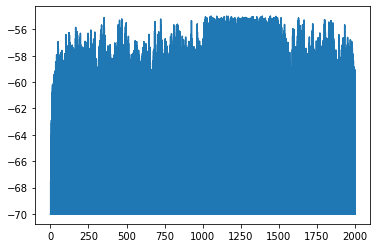

In [29]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

plt.figure(1)
plt.plot(ts, Vms)
plt.show()

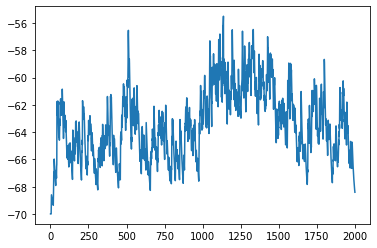

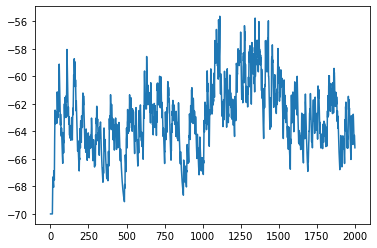

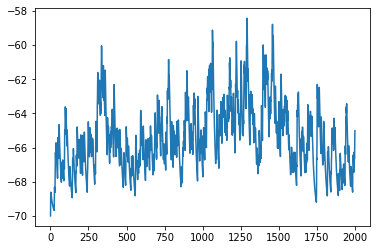

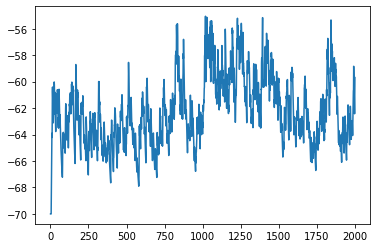

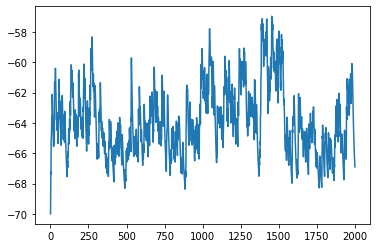

In [30]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

    plt.figure(1)
    plt.plot(ts1, Vms1)
    plt.show()

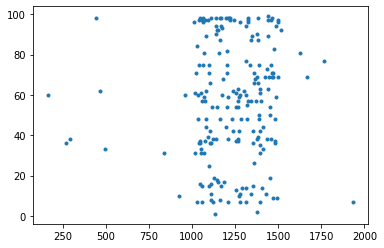

In [31]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.figure(2)
plt.plot(ts, evs, ".")
plt.show()

In [32]:
print("Senders of events(IDs) :", evs)
print("Spike times: ", ts)

Senders of events(IDs) : [60 36 38 98 62 33 31 10 60 96 61 31 71 84  7 48 60 36 75 97 16 37 36 98
 31 61 33  7 97 15 57 75 96 98 31 59 81 57 37 97 62 48 44 89 39 97 15 71
 25 75 66 36 42  8 16 36 98 11 54 38  7 19  1 38 90 98 94 54 18 92 92 17
 81  8 87 98 48 15 94 98 60 93 68 17 44 98 71 82 54 75  7 98 59 38 98 97
 98 48 42 62 97 13 54 37 61 54 38 57 37 63 10 42 59 60 11 96  7 48 14 62
 14 94 60 77  7 55 48 57 96 97 98 75 87 57 11 89 42 36 15 66 26 71 68 57
 38 90 69  2 39 98 66 87 50 48 75 42 31 61  7 35 63 14 57 44 33 69 11 38
 73 99 89 97 63 69 50 19 54 75 38 97 71 98 69 71 69  9 83 36 48 37 94 59
  9 96 97 69 92 81 69 77  7]
Spike times:  [ 167.   266.8  292.4  444.4  469.5  498.2  837.   926.8  961.6 1010.8
 1017.2 1018.1 1024.4 1026.8 1029.7 1033.8 1037.2 1038.7 1040.3 1043.7
 1047.7 1047.3 1048.1 1048.5 1051.2 1054.4 1055.1 1057.  1057.7 1060.6
 1060.5 1062.6 1065.5 1065.2 1068.8 1070.2 1072.5 1074.2 1076.6 1078.1
 1079.7 1082.9 1083.8 1084.3 1091.5 1092.2 1097.4 1098.5 1099.4 

In [37]:
d = {}
for key, val in evs, ts:
    d.setdefault(key, []).append(val)

print(d)

ValueError: too many values to unpack (expected 2)

In [36]:
print(spk_dict.get(92))

1514.2


### OTHERS

In [ ]:
##### HOW TO ENSURE THAT THE INFORMATION WAS PROPERLY INSERTED? THAT IS, THAT THE CONNECTIONS ARE EQUAL TO THE NEST ONES######
# NO NEED TO PROVE THIS. BUT THIS CONN MATRIX, IF I MANAGE TO ORDER NEURONS BY THEIR TYPE, CAN PROVIDE INSIGHTS NONETHELESS
conns = nest.GetConnections(s_nodes, s_nodes)  # This returns a SynapseCollection
# We can get desired information of the SynapseCollection with simple get() call.
g = conns.get(['source', 'target', 'weight'])
srcs = g['source']
tgts = g['target']
weights = g['weight']

# Plot the matrix consisting of the weights between the sources and targets
plt.figure(figsize=(12, 10))
plotMatrix(srcs, tgts, weights, 'Uniform weight', 121)

In [ ]:
def plotRaster(folder_path, size):
    ''' Given a path to a folder inside NEURON-data, generates the raster plot for the corresponding simulation
        (folder_path is "NEURON-data/net_X" )
    '''    
    spikes_dict = getSpikes(folder_path, size)
    
    n_ids = np.array(list(spikes_dict.keys()), dtype=int)
    n_ids.sort() #organize the neurons by id

    neuron_matrix = getNeuronMatrix(folder_path)
    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_matrix)
    
    orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


    fig_handle = plt.figure()
    ax = fig_handle.add_subplot(111)
    ax.set_xlabel('$t$ (ms)')

    plotSpikes(spikes_dict, fs_ID, orderedIDs, fs_color, 'fs', ax)
    plotSpikes(spikes_dict, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
    plotSpikes(spikes_dict, lts_ID, orderedIDs, lts_color, 'lts', ax)
    plotSpikes(spikes_dict, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
    plotSpikes(spikes_dict, chin_ID, orderedIDs, chin_color, 'chin', ax)


    plt.legend()
    plt.show()
